# GMMs
An example for you to work through... 

Execute the cells one by one, and follow the directions.

In [1]:
# things we will need to do stuff in this notebook
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from matplotlib.colors import LogNorm
from matplotlib.patches import Ellipse

# two useful data viz libraries
import matplotlib.pyplot as plt
import seaborn as sns


# setup plotting in a notebook in a reasonable way
%matplotlib inline
%config InlineBackend.figure_format='retina'

# default figure aesthetics I'll be using, 
# there are other choices, see seaborn docs
sns.set_style("white")
sns.set_context("notebook")

# helper functions for later
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle=angle, **kwargs))
        
def plot_gmm(gmm, X, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='Set3')
    ax.axis('equal')
    w_factor = 0.2 / gmm.weights_.max()
    
    if gmm.covariance_type=='diag':
        fullc = np.array([ np.diag(x) for x in gmm.covariances_])
    elif gmm.covariance_type=='spherical':
        fullc = np.array([ np.diag([x, x]) for x in gmm.covariances_])
    elif gmm.covariance_type=='tied':
        fullc = np.array( gmm.n_components*[gmm.covariances_])
    elif gmm.covariance_type=='full':
        fullc = gmm.covariances_
    else:
        raise NotImplemented
        
    for pos, covar, w in zip(gmm.means_, fullc, gmm.weights_):
        alph = np.max([w*w_factor, 0.05])
        draw_ellipse(pos, covar, ax=ax, alpha=alph)

# difficult data
Execute the cell below to see some difficult to cluster toy data

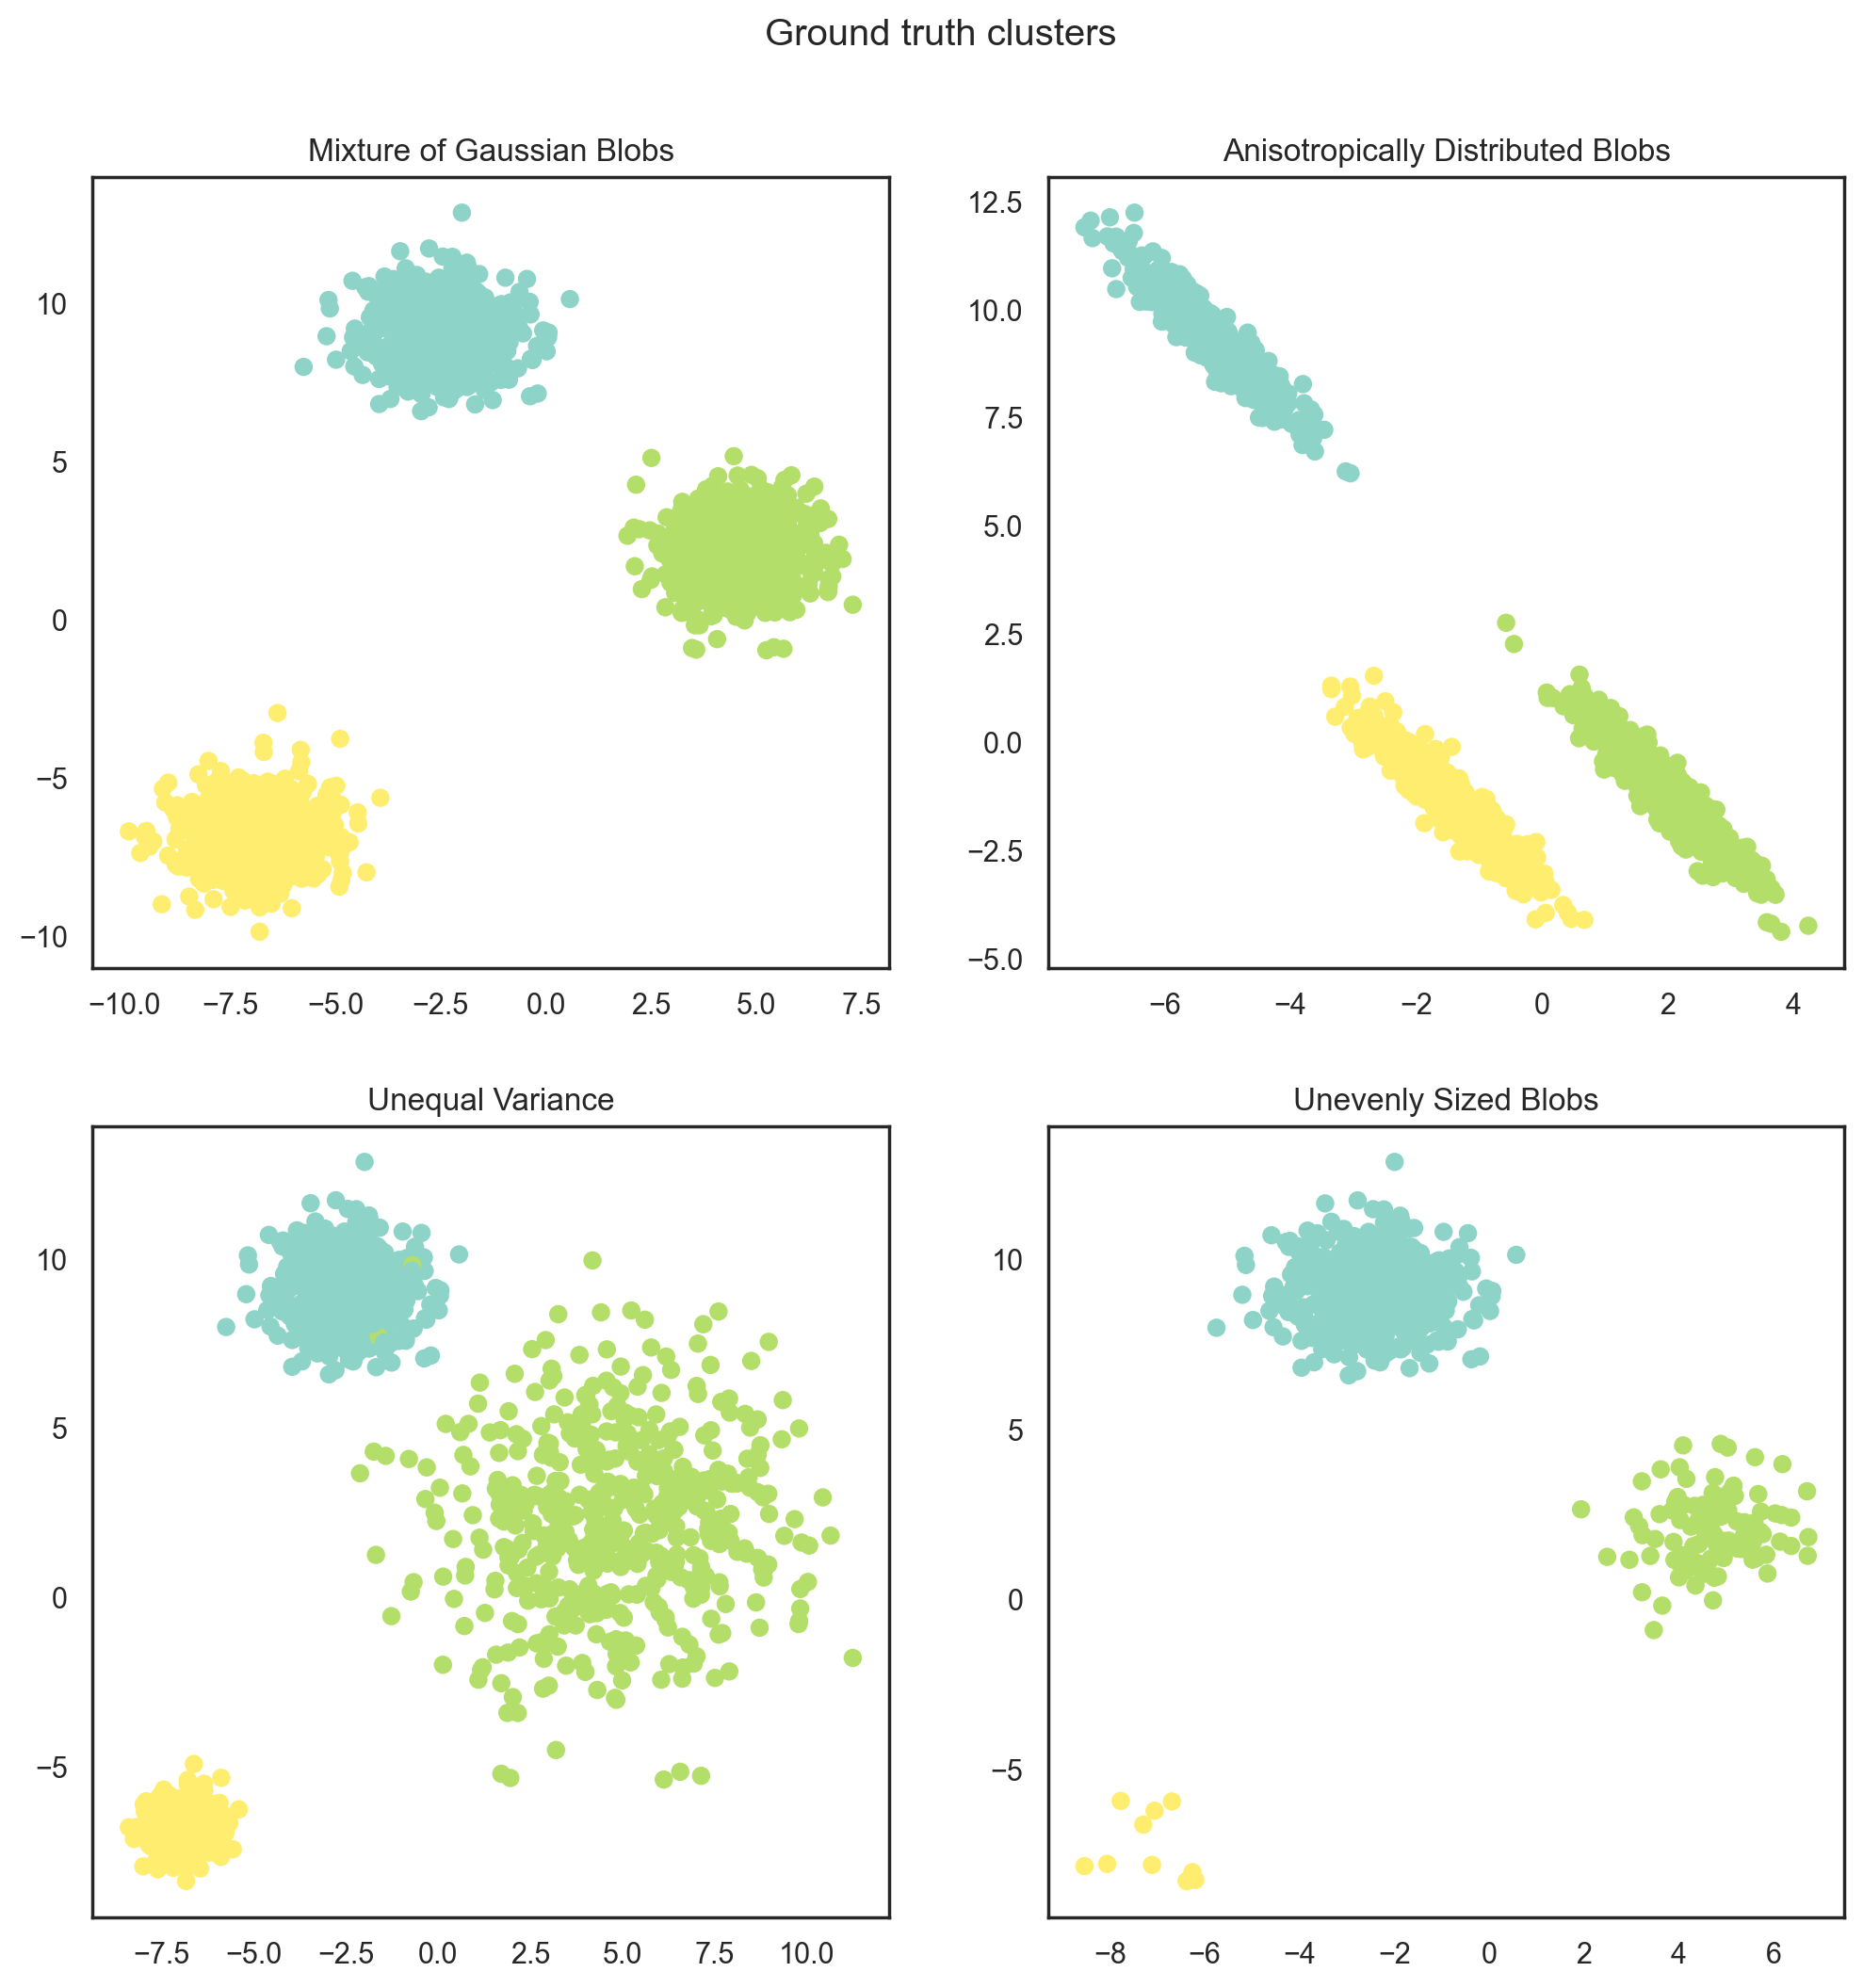

In [2]:


n_samples = 1500
random_state = 42
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
common_params = {
    "random_state": random_state,
}


X, y = make_blobs(n_samples=n_samples, random_state=random_state)
X_aniso = np.dot(X, transformation)  # Anisotropic blobs
X_varied, y_varied = make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)  # Unequal variance
X_filtered = np.vstack(
    (X[y == 0][:500], X[y == 1][:100], X[y == 2][:10])
)  # Unevenly sized blobs
y_filtered = [0] * 500 + [1] * 100 + [2] * 10



fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

axs[0, 0].scatter(X[:, 0], X[:, 1], c=y, cmap='Set3')
axs[0, 0].set_title("Mixture of Gaussian Blobs")


axs[0, 1].scatter(X_aniso[:, 0], X_aniso[:, 1], c=y, cmap='Set3')
axs[0, 1].set_title("Anisotropically Distributed Blobs")

axs[1, 0].scatter(X_varied[:, 0], X_varied[:, 1], c=y_varied, cmap='Set3')
axs[1, 0].set_title("Unequal Variance")

axs[1, 1].scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_filtered, cmap='Set3')
axs[1, 1].set_title("Unevenly Sized Blobs")

plt.suptitle("Ground truth clusters").set_y(0.95)

plt.show()

# kmeans
 Now execute this cell to see how K-means deals with those datasets

/Users/olimpiacarrioli/Assignments_WI24-1/COGS118B_venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/olimpiacarrioli/Assignments_WI24-1/COGS118B_venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/olimpiacarrioli/Assignments_WI24-1/COGS118B_venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/olimpiacarrioli/Assignments_WI24-1/COGS118

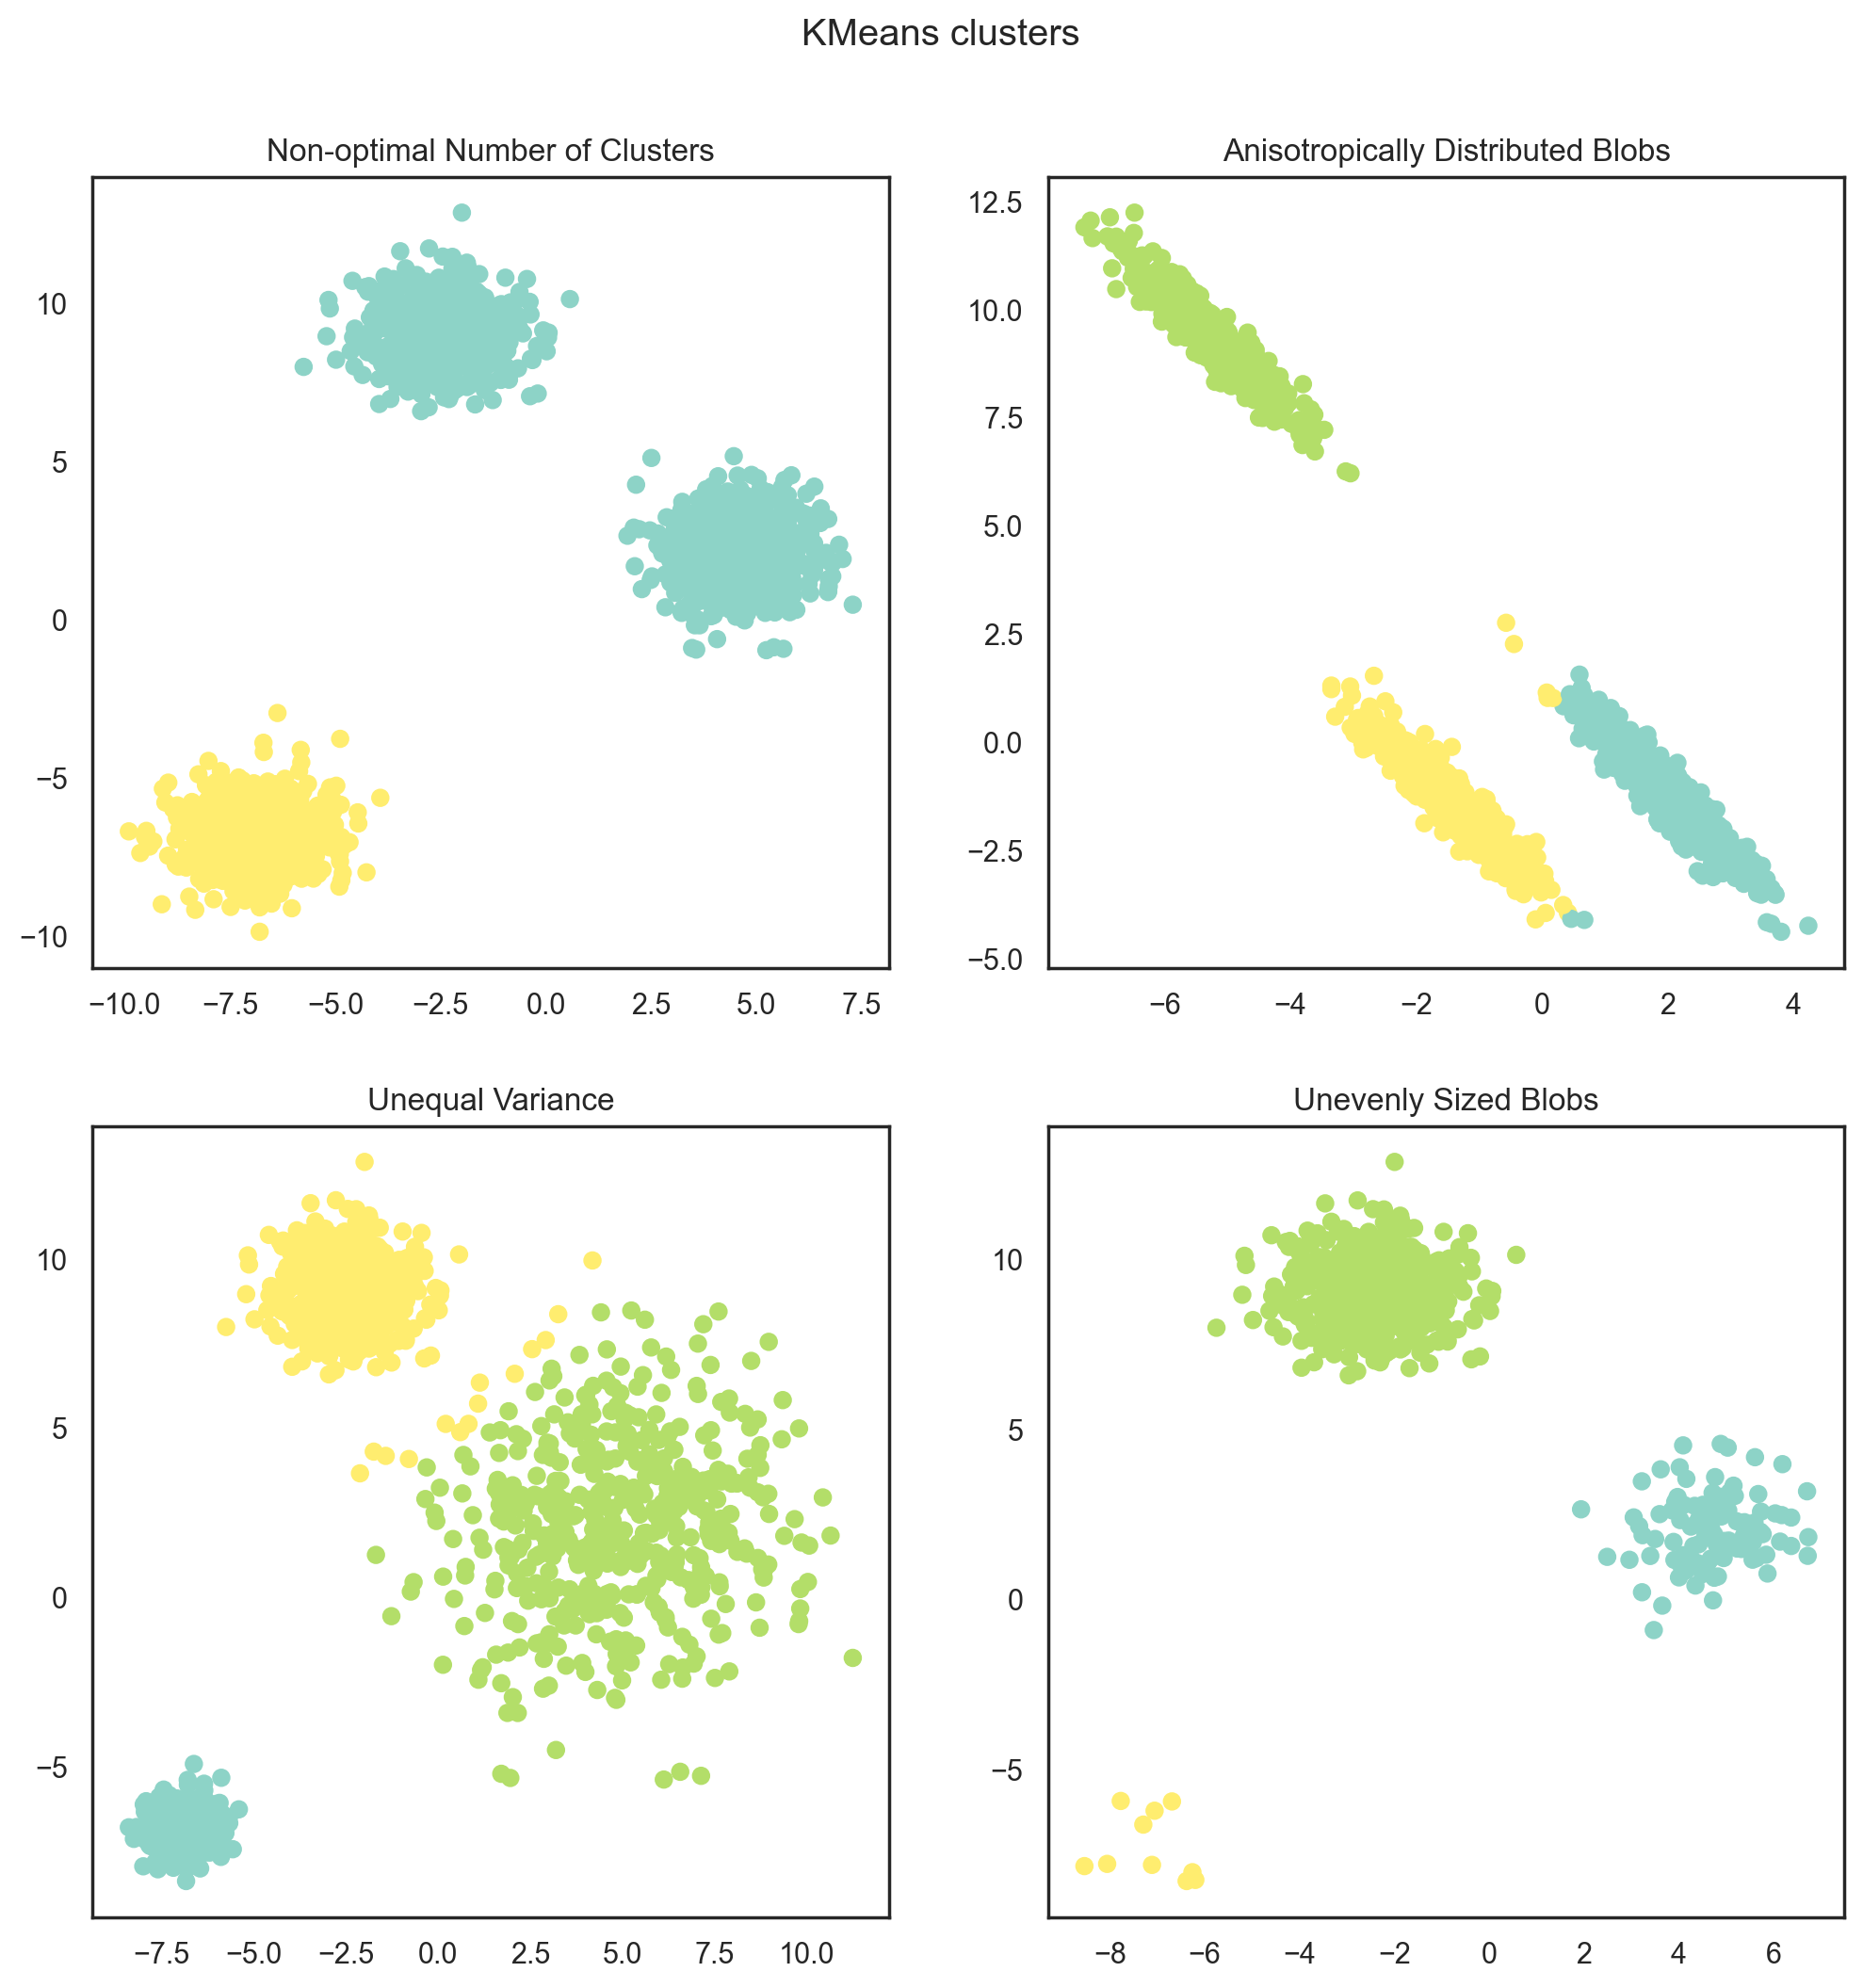

In [3]:


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

y_pred = KMeans(n_clusters=2, **common_params).fit_predict(X)
axs[0, 0].scatter(X[:, 0], X[:, 1], c=y_pred, cmap='Set3')
axs[0, 0].set_title("Non-optimal Number of Clusters")

y_pred = KMeans(n_clusters=3, **common_params).fit_predict(X_aniso)
axs[0, 1].scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred, cmap='Set3')
axs[0, 1].set_title("Anisotropically Distributed Blobs")

y_pred = KMeans(n_clusters=3, **common_params).fit_predict(X_varied)
axs[1, 0].scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred, cmap='Set3')
axs[1, 0].set_title("Unequal Variance")

y_pred = KMeans(n_clusters=3, **common_params).fit_predict(X_filtered)
axs[1, 1].scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred, cmap='Set3')
axs[1, 1].set_title("Unevenly Sized Blobs")

plt.suptitle("KMeans clusters").set_y(0.95)
plt.show()

## GMM
Compare the K-means solutions above to the different kinds of Gaussian Mixture Model solutions below

Go to the (scikit-learn docs for GMM)[https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture].  Read the function definition and understand the arguments, especially the different kinds of allowable covariance types.

Generically some forms of covariance allow more powerful fitting to the data, and some forms of the model are more restricted, forcing a simpler form interpretation of the data.  Maybe read a bit about the bias - variance tradeoff if you are unfamiliar with what I'm saying :) 

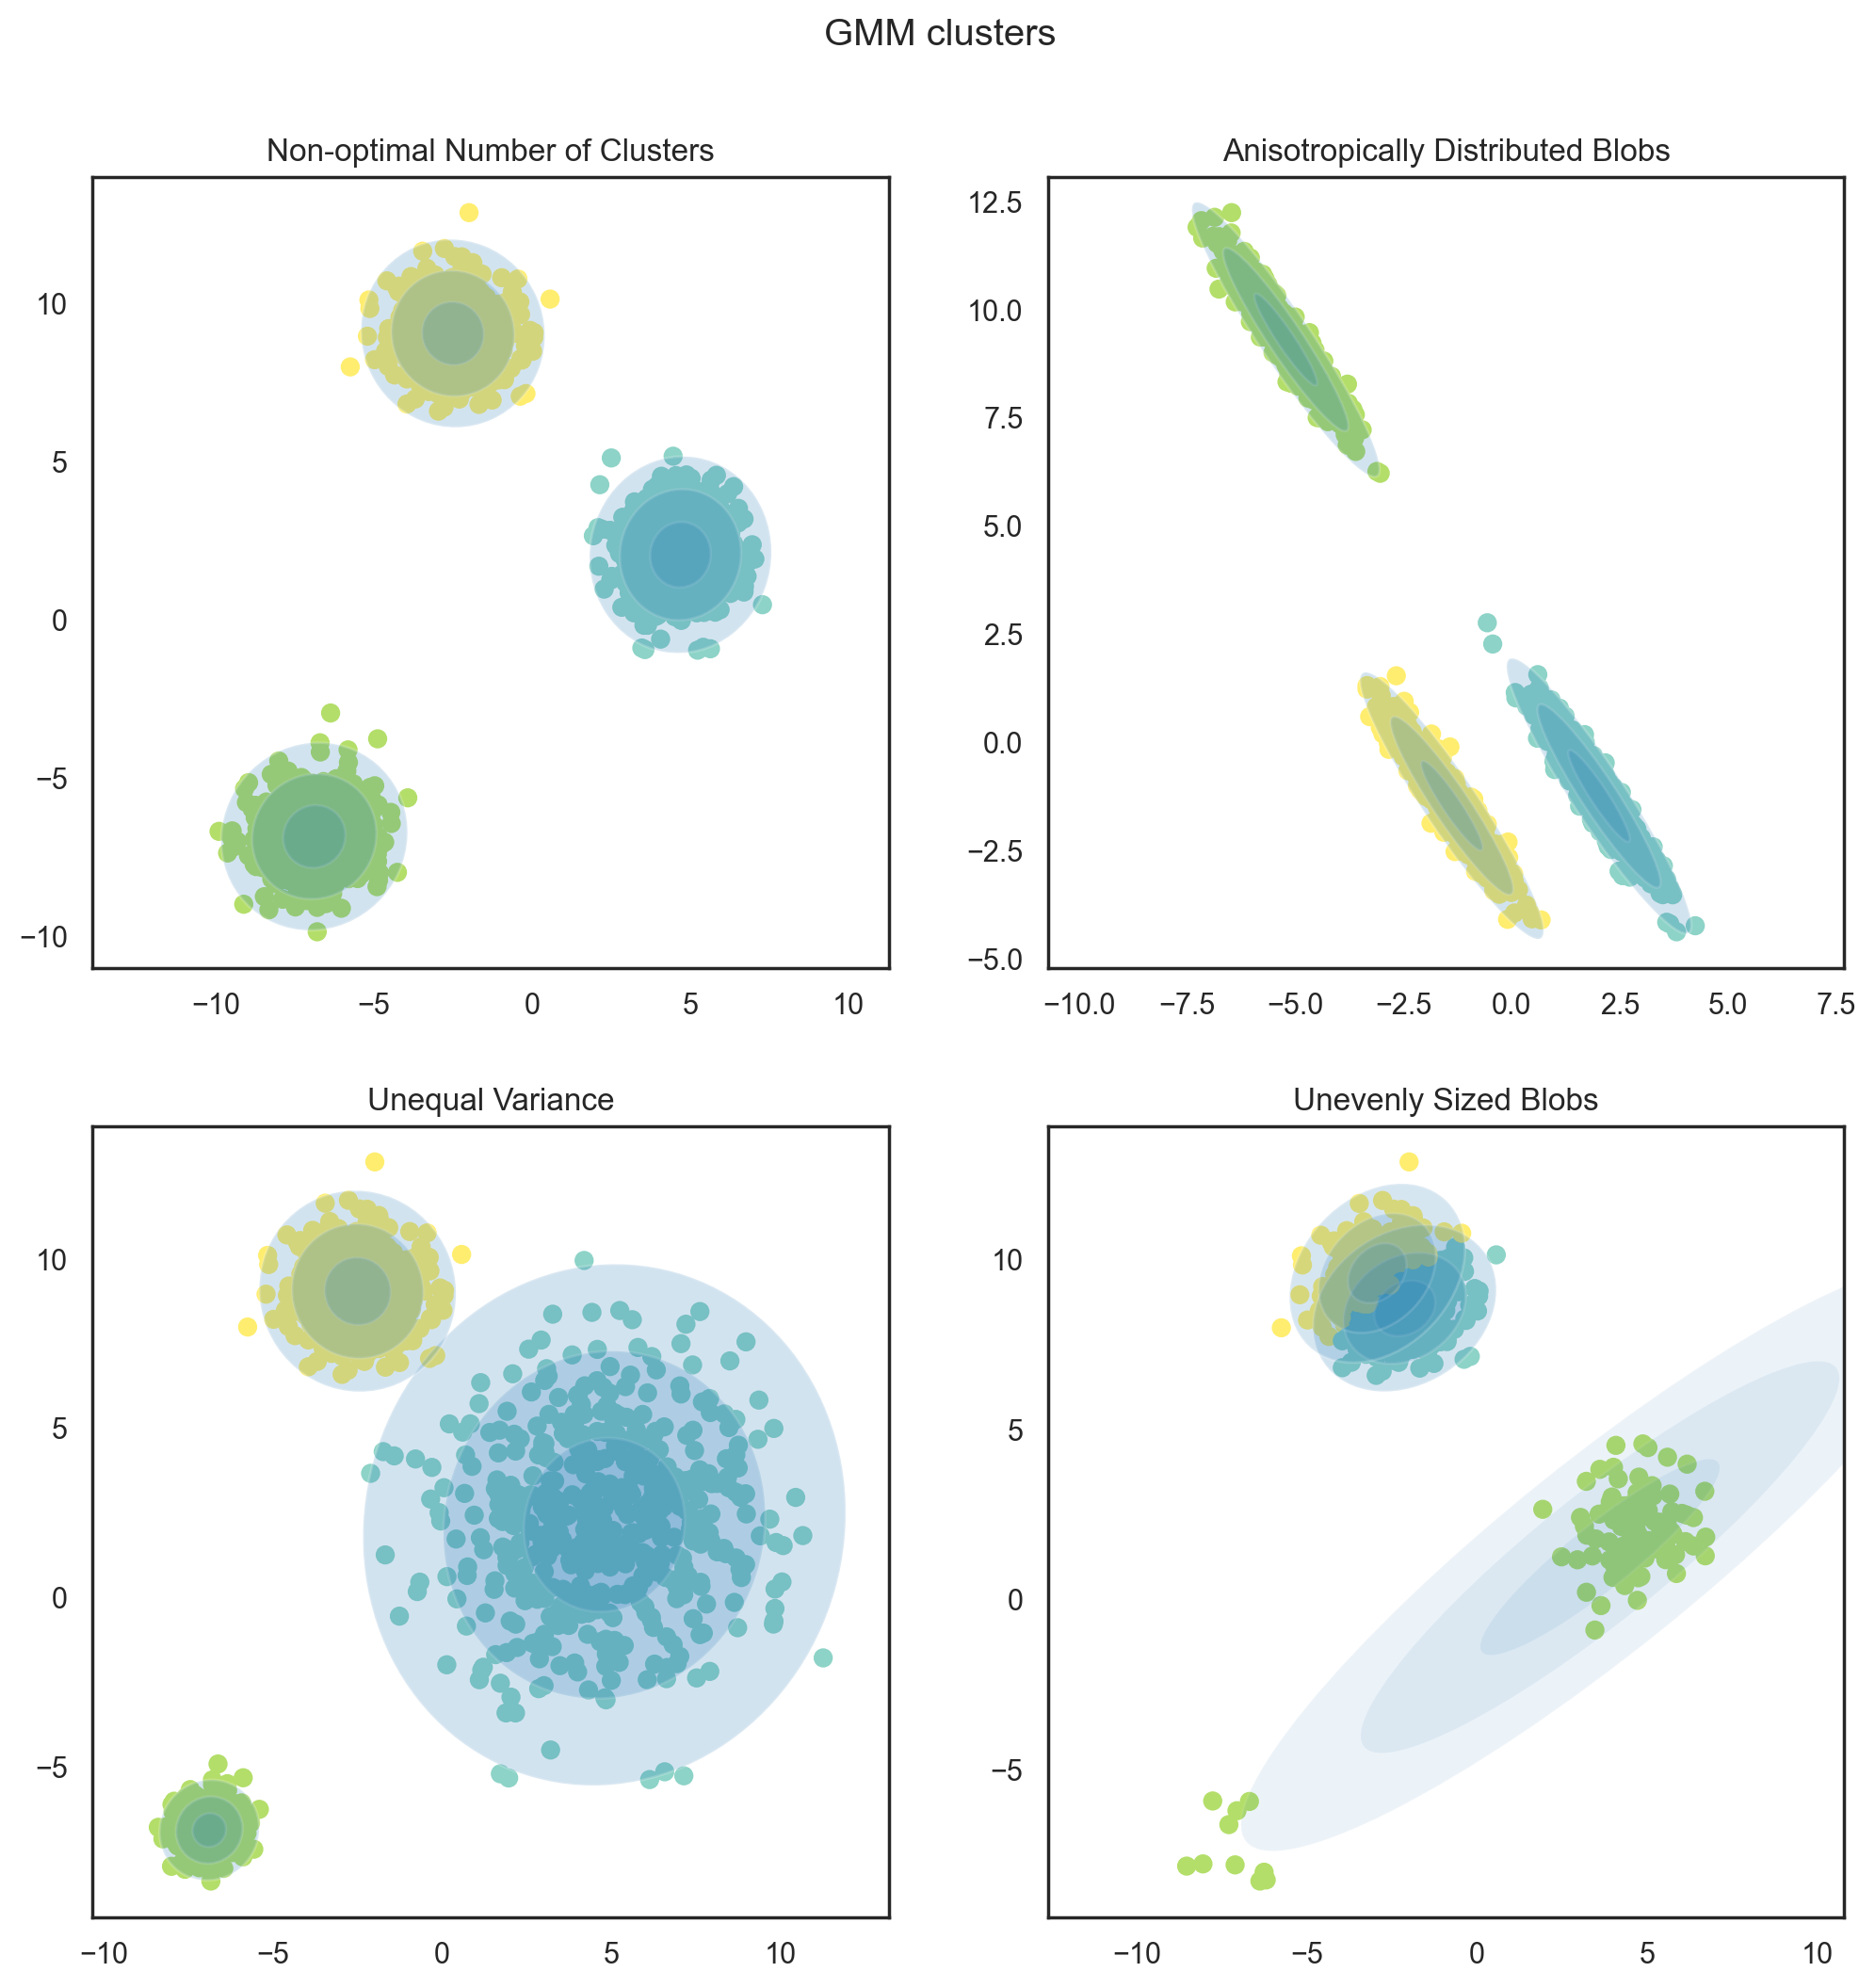

In [9]:
k = 3

# try all the the different covariance_types for GMM
cov = 'full' #your answers here


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

plot_gmm( GaussianMixture(n_components=k, covariance_type=cov, **common_params), X, ax=axs[0,0])
axs[0, 0].set_title("Non-optimal Number of Clusters")

plot_gmm( GaussianMixture(n_components=k, covariance_type=cov, **common_params), X_aniso,  ax=axs[0,1])
axs[0, 1].set_title("Anisotropically Distributed Blobs")

plot_gmm( GaussianMixture(n_components=k, covariance_type=cov, **common_params), X_varied, ax=axs[1,0])
axs[1, 0].set_title("Unequal Variance")

plot_gmm( GaussianMixture(n_components=k, covariance_type=cov, **common_params), X_filtered, ax=axs[1,1])
axs[1, 1].set_title("Unevenly Sized Blobs")

plt.suptitle("GMM clusters").set_y(0.95)
plt.show()

## go back and explore k
Now do the cell above with some other k values.  See what happens.

## reflect

Compare the K-means (which has one hyper-parameter k) solutions with the different instantiations of GMM solutions (two hyper-parameters, k and covariance_type).  Which solutions are better for these datasets?  When a solution fails, why does it fail? 

Don't get stuck with the idea that there is a "best model" here... because there isn't! Can you imagine a dataset that will make the "best performing" solution here do a worse job than other solutions?